# Animal Image Classification

# Imports

In [63]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageFile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Constants

In [10]:
PATH = "/Users/maukanmir/Downloads/animal_data/"
BATCH_SIZE= 32
INPUT_SHAPE= (224,224,3)

# Functions

In [57]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def process_images(img_path, target_size=INPUT_SHAPE):
  try:
    with Image.open(img_path) as image:
      image = image.resize(target_size[:2])
      image = image.convert("RGB")
      image_array = np.array(image)/255.0
      image_array = image_array.astype(np.float32)
      return image_array
  except IOError as e:
    print(f"There was an error processing this image: {e}")
    return None
  
def grab_images(path):
  
  images, labels = [], []
  
  for root, dir, files in os.walk(path):
    for file in files:
      if file.lower().endswith((".png", ".jpeg", ".jpg")):
        img_path = os.path.join(root, file)
        img = process_images(img_path)
        if img is not None:
          images.append(img)
          label = root.split(os.sep)[-1]
          labels.append(label)
  
  images, labels = np.array(images), np.array(labels)
  
  return images, labels

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 6))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Class Balance")
  plt.xticks(rotation=45)
  plt.show()
  
  plt.figure(figsize=(10,6))
  sns.countplot(x=target)
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plt_images(images, labels, num_images=12, img_size=INPUT_SHAPE):
  indices = np.arange(len(images))
  np.random.shuffle(indices) 
  plt.figure(figsize=(10,10))
  
  for i in range(num_images):
    plt.subplot(3, 4, i+1)
    idx = indices[i]
    img = images[idx].reshape(img_size)
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis("off")
  plt.show()

def create_model(n_classes, input_shape=INPUT_SHAPE):
  
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=INPUT_SHAPE),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(n_classes, activation="softmax")
  ])
  
  model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  model.summary()
  
  return model
    

# Load in Dataset

In [52]:
X, y = grab_images(PATH)

# EDA Analysis

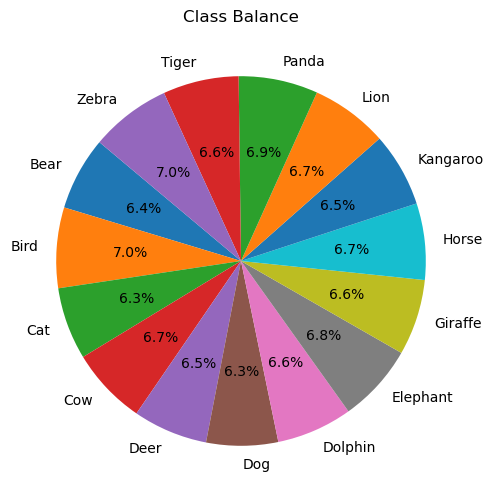

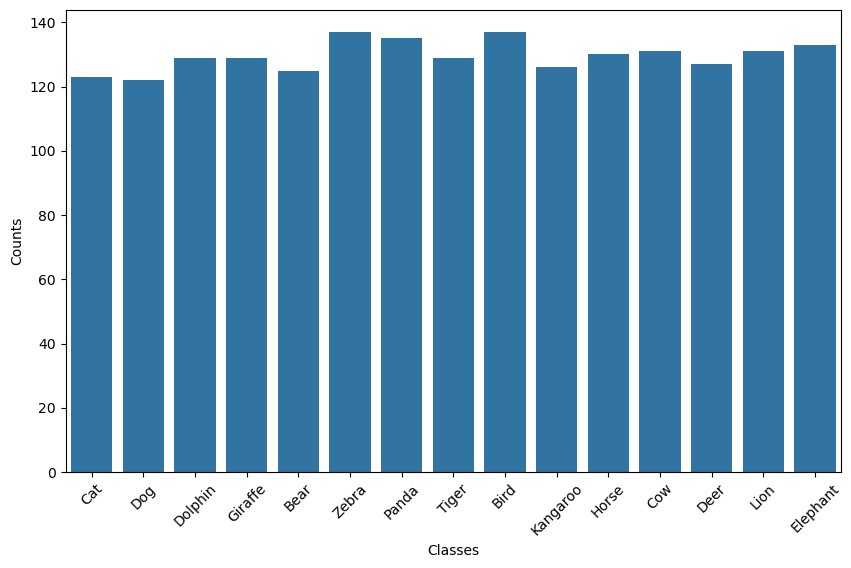

In [42]:
check_class_imbalance(y)

# Class is moderately Balanced

# Lets get a look at some of our images

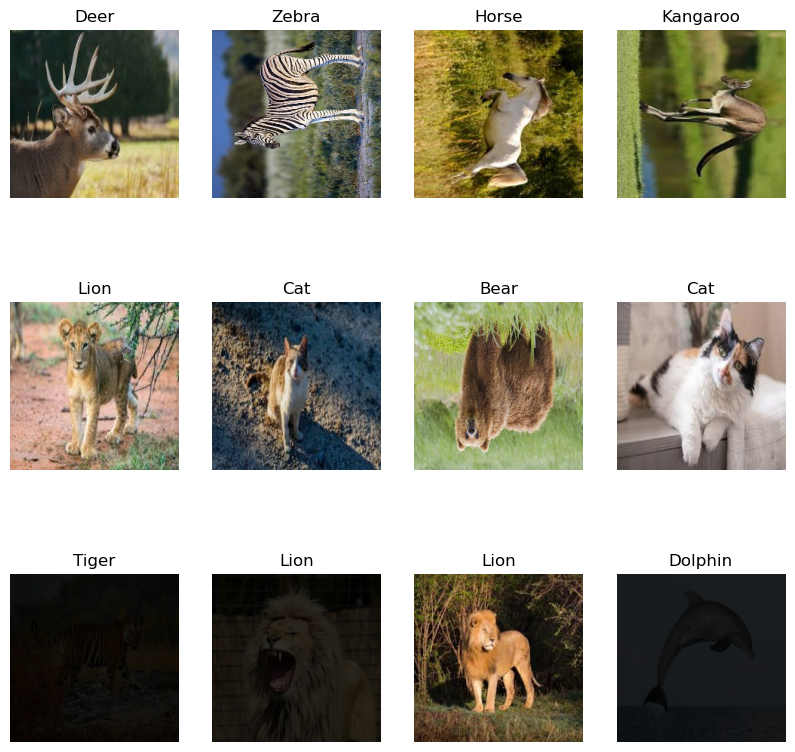

In [49]:
plt_images(X, y)

# The Dataset seems to be augmented so there will be no need to incorporate my own augmentation

# Transform Target Data

In [53]:
label_encoder = LabelEncoder()

y_int = label_encoder.fit_transform(y)

# Split Data into Train, Test and Validation splits

In [54]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [59]:
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 1166
Validation set size: 389
Test set size: 389


# Minor Data augmentation

In [61]:
train_datagen = ImageDataGenerator(
  rotation_range=40,
  fill_mode="nearest"
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train,
  y_train,
  batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow(
  X_val,
  y_val,
  batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow(
  X_test,
  y_test,
  batch_size=BATCH_SIZE
)

# Create Model

In [62]:
create_model(len(label_encoder.classes_))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

# Early Stopping and Step Size